In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from scipy.stats import shapiro
from scipy.stats import levene
import scipy.stats as stats
from itertools import cycle, islice

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_scatter(df, cols, col_y = 'amount'):
    for col in cols:
        fig = plt.figure(figsize=(7,6)) # define plot area
        ax = fig.gca() # define axis   
        df.plot.scatter(x = col, y = col_y, ax = ax)
        ax.set_title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel(col_y
                     )# Set text for y axis
        plt.show()

In [3]:
def plot_box(df, cols, col_y = 'amount'):
    for col in cols:
        plt.figure(figsize=(18,3))
        sns.set_style("whitegrid")
        sns.boxplot(col_y, col, data=df, orient="h", showmeans=True)
        plt.xlabel(col_y) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()
        


In [4]:
def plot_violin(df, cols, col_y = 'amount'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.violinplot(col, col_y, data=df)
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.show()

In [5]:
def plot_density_hist(df, cols, bins = 10, hist = False):
    for col in cols:
        sns.set_style("whitegrid")
        sns.distplot(df[col], bins = bins, rug=True, hist = hist)
        plt.title('Histogram of ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel('Number of autos')# Set text for y axis
        plt.show()  

Healthcare Dataset Challenge: The task is to analyze the clinical and financial data of patients hospitalized for a certain condition. It is attached with this email. Some variable names and patient_id's have been anonymized in this dataset. You are required to join the data given in different tables, and find insights about the drivers of cost of care. Please see attached documents for datasets

Hypotheses to test:


    1. Positive Linear Correlation with Age at admission (Admission date - DOB)
    
    2. Point Biserial for Medical History, Symptoms
    
    3. Length of stay
    
    4. Resident status

In [6]:
df = pd.read_csv('challenge_data_treated.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bill_id             13600 non-null  int64  
 1   amount              13600 non-null  float64
 2   patient_id          13600 non-null  object 
 3   date_of_admission   13600 non-null  object 
 4   date_of_discharge   13600 non-null  object 
 5   medical_history_1   13600 non-null  int64  
 6   medical_history_2   13600 non-null  int64  
 7   medical_history_3   13600 non-null  int64  
 8   medical_history_4   13600 non-null  int64  
 9   medical_history_5   13600 non-null  int64  
 10  medical_history_6   13600 non-null  int64  
 11  medical_history_7   13600 non-null  int64  
 12  preop_medication_1  13600 non-null  int64  
 13  preop_medication_2  13600 non-null  int64  
 14  preop_medication_3  13600 non-null  int64  
 15  preop_medication_4  13600 non-null  int64  
 16  preo

# 1. Creating additional features for analysis

In [8]:
# Age of patient at visit

dtdoa = pd.to_datetime(df['date_of_admission'])
dtdob = pd.to_datetime(df['date_of_birth'])
age_at_visit = []

for i, j in zip(dtdoa[0:], dtdob[0:]):
    one_or_zero = ((i.month, i.day) < (j.month, j.day))
    year_difference = i.year - j.year
    age = year_difference - one_or_zero
    age_at_visit.append(age)
    
df['age_at_visit'] = age_at_visit

In [9]:
# Length of patients' stay at each visit

dtdoa = pd.to_datetime(df['date_of_admission'])
dtdod = pd.to_datetime(df['date_of_discharge'])
length_of_stay = []

for i, j in zip(dtdoa[0:], dtdod[0:]):
    f_date = date(i.year, i.month, i.day)
    l_date = date(j.year, j.month, j.day)
    delta = l_date - f_date
    length_of_stay.append(delta.days)
    
df['length_of_stay'] = length_of_stay

In [10]:
# Extent of Medical History of patient

df_mh = df[['medical_history_1', 'medical_history_2', 'medical_history_3', 
            'medical_history_4', 'medical_history_5', 'medical_history_6', 'medical_history_7']]
df['mh_sum'] = df_mh.sum(axis = 1)

In [11]:
# Number of presenting symptoms at each visit

df_symp = df[['symptom_1', 'symptom_2', 'symptom_3', 
            'symptom_4', 'symptom_5']]
df['symp_sum'] = df_symp.sum(axis = 1)

In [12]:
# Number of medications prescribed at each visit

df_meds = df[['preop_medication_1', 'preop_medication_2', 'preop_medication_3', 
            'preop_medication_4', 'preop_medication_5', 'preop_medication_6']]
df['meds_sum'] = df_meds.sum(axis = 1)


In [13]:
# Incorporating Weight and Height into a single feature (BMI)
# BMI = mass (kg) / height2 (m)

wt = df['weight']
ht = df['height']
bmi = []

for i, j in zip(wt[0:], ht[0:]):
    bmi_calc = i / ((j/100)**2)
    bmi.append(bmi_calc)
    
df['bmi'] = bmi

In [14]:
df.columns

Index(['bill_id', 'amount', 'patient_id', 'date_of_admission',
       'date_of_discharge', 'medical_history_1', 'medical_history_2',
       'medical_history_3', 'medical_history_4', 'medical_history_5',
       'medical_history_6', 'medical_history_7', 'preop_medication_1',
       'preop_medication_2', 'preop_medication_3', 'preop_medication_4',
       'preop_medication_5', 'preop_medication_6', 'symptom_1', 'symptom_2',
       'symptom_3', 'symptom_4', 'symptom_5', 'lab_result_1', 'lab_result_2',
       'lab_result_3', 'weight', 'height', 'gender', 'race', 'resident_status',
       'date_of_birth', 'age_at_visit', 'length_of_stay', 'mh_sum', 'symp_sum',
       'meds_sum', 'bmi'],
      dtype='object')

In [15]:
df.describe()

,bill_id,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,...,height,gender,race,resident_status,age_at_visit,length_of_stay,mh_sum,symp_sum,meds_sum,bmi
count,1.360000e+04,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,...,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000
mean,5.007147e+09,5464.767783,0.169118,0.290000,0.136176,0.052059,0.058235,0.254706,0.254412,0.503824,...,165.084412,0.499412,0.571765,0.246176,52.039412,11.051176,1.214706,3.080000,4.002941,28.958874
std,2.885919e+09,7717.479509,0.374870,0.453779,0.342988,0.222154,0.234196,0.435712,0.435546,0.500004,...,6.972908,0.500018,0.877611,0.529434,14.696105,2.849826,0.971884,1.068606,1.106701,4.140217
min,5.584120e+05,79.496707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,151.000000,0.000000,0.000000,0.000000,21.000000,1.000000,0.000000,0.000000,0.000000,17.508651
25%,2.485853e+09,950.689008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,160.000000,0.000000,0.000000,0.000000,39.000000,9.000000,0.000000,2.000000,3.000000,26.156074
50%,4.992958e+09,1516.951136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,165.000000,0.000000,0.000000,0.000000,50.000000,11.000000,1.000000,3.000000,4.000000,28.943985
75%,7.524563e+09,7307.056573,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,170.000000,1.000000,1.000000,0.000000,64.250000,13.000000,2.000000,4.000000,5.000000,31.713345
max,9.999633e+09,81849.751340,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,186.000000,1.000000,3.000000,2.000000,85.000000,20.000000,5.000000,5.000000,6.000000,46.677349


In [16]:
#split dataset into numeric / categorical

df_num = df[['amount', 'lab_result_1', 'lab_result_2', 'lab_result_3',
             'weight', 'height', 'age_at_visit', 'length_of_stay',
             'meds_sum', 'mh_sum', 'symp_sum', 'bmi']]
df_cat = df[['amount','medical_history_1', 'medical_history_2',
               'medical_history_3', 'medical_history_4', 'medical_history_5',
               'medical_history_6', 'medical_history_7', 'preop_medication_1',
               'preop_medication_2', 'preop_medication_3', 'preop_medication_4',
               'preop_medication_5', 'preop_medication_6', 'symptom_1', 'symptom_2',
               'symptom_3', 'symptom_4', 'symptom_5', 'gender', 'race', 'resident_status']]

# 2. Time

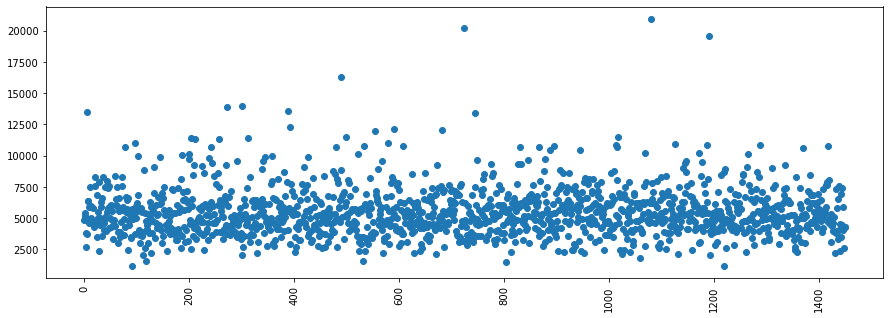

In [17]:
df_time = df[['amount', 'date_of_admission']]
df_time = df_time.sort_values('date_of_admission')
df_timegb = df_time.groupby('date_of_admission')['amount'].mean().reset_index(drop = True)
plt.figure(figsize = (15,5))
plt.scatter(df_timegb.index, df_timegb)
plt.xticks(rotation = 90)
plt.show()

#### Cost remains fairly constant across time period (5 years)

# 3. Numerical Variables

In [18]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   amount          13600 non-null  float64
 1   lab_result_1    13600 non-null  float64
 2   lab_result_2    13600 non-null  float64
 3   lab_result_3    13600 non-null  float64
 4   weight          13600 non-null  float64
 5   height          13600 non-null  float64
 6   age_at_visit    13600 non-null  int64  
 7   length_of_stay  13600 non-null  int64  
 8   meds_sum        13600 non-null  int64  
 9   mh_sum          13600 non-null  int64  
 10  symp_sum        13600 non-null  int64  
 11  bmi             13600 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 1.2 MB


In [19]:
df_num.corr()

,amount,lab_result_1,lab_result_2,lab_result_3,weight,height,age_at_visit,length_of_stay,meds_sum,mh_sum,symp_sum,bmi
amount,1.000000,-0.002144,-0.001821,0.000030,0.051811,0.008571,0.107089,0.002962,0.013112,0.064078,0.167653,0.046170
lab_result_1,-0.002144,1.000000,0.004194,-0.006332,0.004847,-0.001204,-0.013940,0.009821,0.015578,0.027540,-0.007910,0.006518
lab_result_2,-0.001821,0.004194,1.000000,0.025324,-0.019385,-0.005014,-0.000695,-0.033206,-0.020187,-0.019425,-0.016634,-0.015005
lab_result_3,0.000030,-0.006332,0.025324,1.000000,-0.017923,0.009280,0.010564,-0.009022,-0.036382,-0.015546,-0.016534,-0.023021
weight,0.051811,0.004847,-0.019385,-0.017923,1.000000,0.270154,-0.014986,-0.017557,-0.001685,0.014119,0.016593,0.816531
height,0.008571,-0.001204,-0.005014,0.009280,0.270154,1.000000,0.007540,-0.027690,-0.010933,0.000494,0.009160,-0.329692
age_at_visit,0.107089,-0.013940,-0.000695,0.010564,-0.014986,0.007540,1.000000,0.003274,-0.008778,-0.002817,0.003583,-0.017312
length_of_stay,0.002962,0.009821,-0.033206,-0.009022,-0.017557,-0.027690,0.003274,1.000000,-0.009281,0.018122,-0.002793,-0.000944
meds_sum,0.013112,0.015578,-0.020187,-0.036382,-0.001685,-0.010933,-0.008778,-0.009281,1.000000,0.009258,0.039596,0.004517
mh_sum,0.064078,0.027540,-0.019425,-0.015546,0.014119,0.000494,-0.002817,0.018122,0.009258,1.000000,-0.005778,0.014012


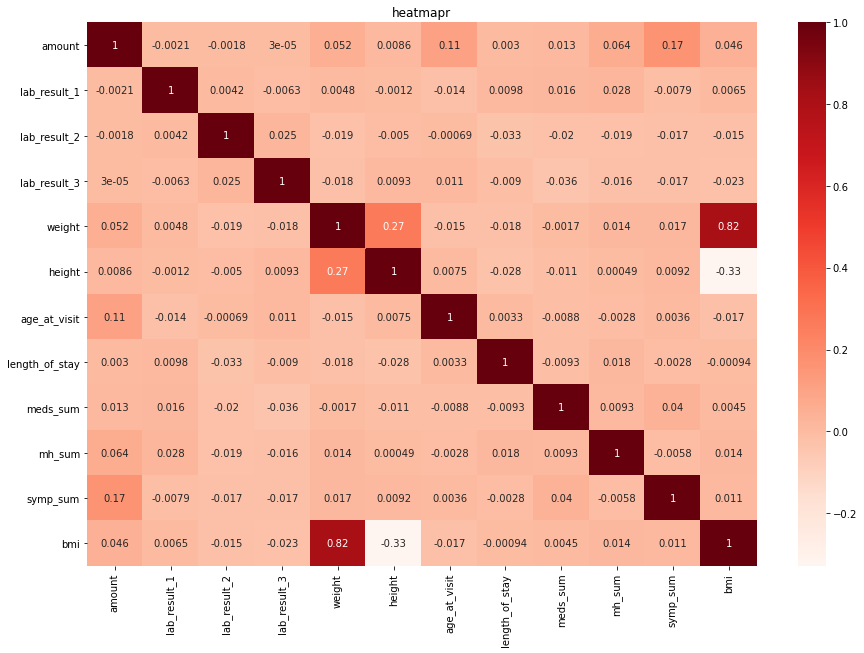

In [20]:
plt.figure(figsize = (15,10))
sns.heatmap(df_num.corr(), cmap = plt.cm.Reds, annot= True)
plt.title("heatmapr")
plt.show()

,Numerical Variable,Correlation with mean bill amount
0,Age at visit,0.858545
1,Length of stay,-0.310142
2,Number of medications prescribed,0.543059
3,Extent of medical history,0.870758
4,Number of presenting symptoms,0.999774
5,Body Mass Index,0.154970


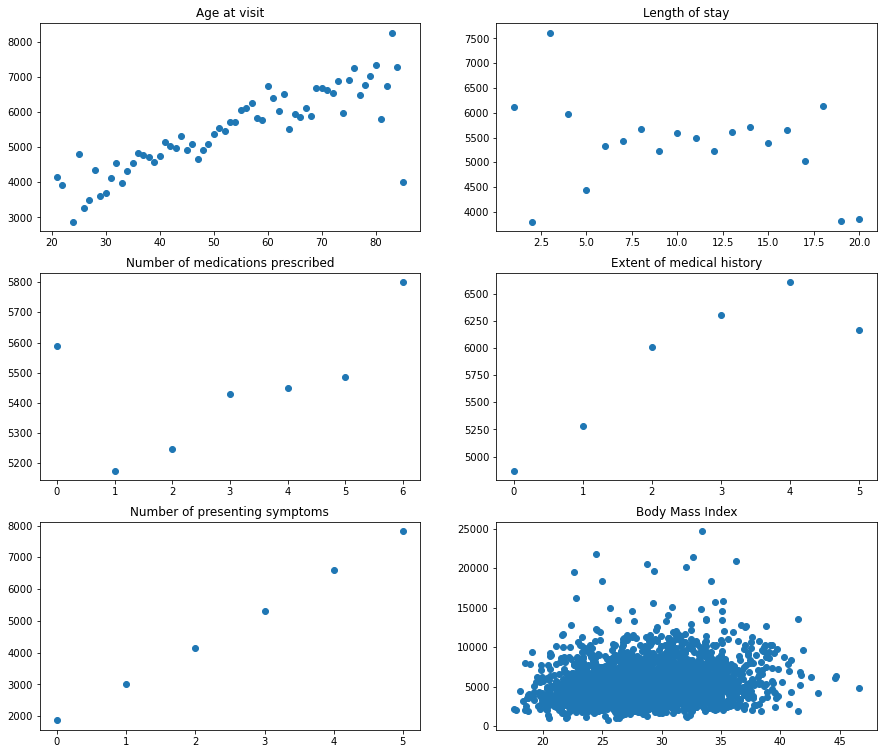

In [21]:
# use of mean bill amounts to get average cost for patient across multiple variables

fig, axarr = plt.subplots(3,2, figsize = (15,13))

ba_mean_age = df_num.groupby('age_at_visit')['amount'].mean().reset_index()
axarr[0,0].scatter(ba_mean_age.age_at_visit.values, ba_mean_age.amount)
axarr[0,0].set_title("Age at visit")

ba_mean_length = df_num.groupby('length_of_stay')['amount'].mean().reset_index()
axarr[0,1].scatter(ba_mean_length.length_of_stay.values, ba_mean_length.amount)
axarr[0,1].set_title("Length of stay")

ba_mean_meds_sum = df_num.groupby('meds_sum')['amount'].mean().reset_index()
axarr[1,0].scatter(ba_mean_meds_sum.meds_sum.values, ba_mean_meds_sum.amount)
axarr[1,0].set_title("Number of medications prescribed")

ba_mean_mh_sum = df_num.groupby('mh_sum')['amount'].mean().reset_index()
axarr[1,1].scatter(ba_mean_mh_sum.mh_sum.values, ba_mean_mh_sum.amount)
axarr[1,1].set_title("Extent of medical history")

ba_mean_symp_sum = df_num.groupby('symp_sum')['amount'].mean().reset_index()
axarr[2,0].scatter(ba_mean_symp_sum.symp_sum.values, ba_mean_symp_sum.amount)
axarr[2,0].set_title("Number of presenting symptoms")

ba_mean_bmi = df_num.groupby('bmi')['amount'].mean().reset_index()
axarr[2,1].scatter(ba_mean_bmi.bmi.values, ba_mean_bmi.amount)
axarr[2,1].set_title("Body Mass Index")

df_num_corr = pd.DataFrame({'Numerical Variable': ['Age at visit', 'Length of stay', 'Number of medications prescribed',
                                         'Extent of medical history', 'Number of presenting symptoms', 'Body Mass Index'],
                  
                  'Correlation with mean bill amount': 
                   [ ba_mean_age.age_at_visit.corr(ba_mean_age.amount),
                   ba_mean_length.length_of_stay.corr(ba_mean_length.amount),
                   ba_mean_meds_sum.meds_sum.corr(ba_mean_meds_sum.amount),
                   ba_mean_mh_sum.mh_sum.corr(ba_mean_mh_sum.amount),
                   ba_mean_symp_sum.symp_sum.corr(ba_mean_symp_sum.amount),
                   ba_mean_bmi.bmi.corr(ba_mean_bmi.amount) ]
                  
                  })

df_num_corr




# 4. Categorical Variables

In [22]:
df_cat

,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,...,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,gender,race,resident_status
0,1552.634830,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,1,0
1,27923.446312,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,1,0
2,1952.978141,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,1,0
3,1244.994422,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,1,0
4,1032.011951,0,0,0,0,0,0,0,1,1,...,1,1,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13595,663.585265,0,0,0,0,0,1,0,1,1,...,1,1,1,1,1,1,1,1,0,0
13596,1324.691516,0,1,0,0,0,1,0,1,0,...,1,1,0,0,1,0,1,1,1,0
13597,18386.672482,0,1,0,0,0,1,0,1,0,...,1,1,0,0,1,0,1,1,1,0
13598,5280.005320,0,1,0,0,0,1,0,1,0,...,1,1,0,0,1,0,1,1,1,0


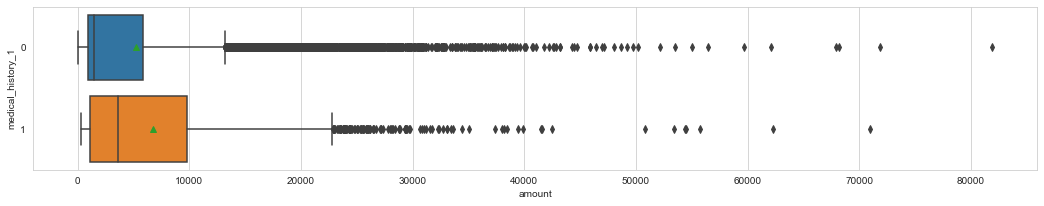

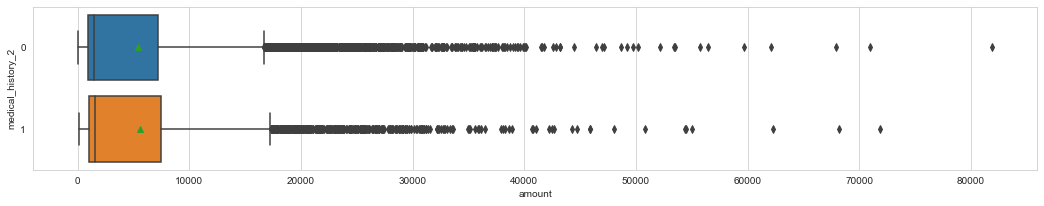

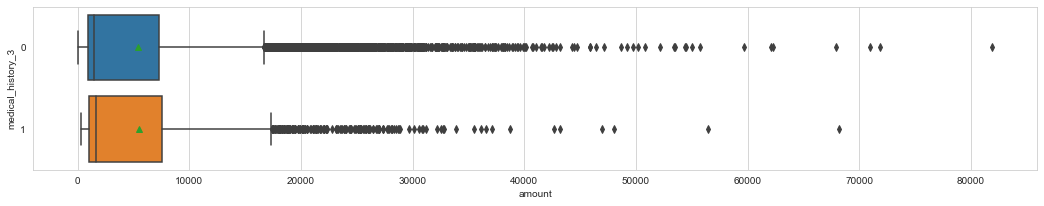

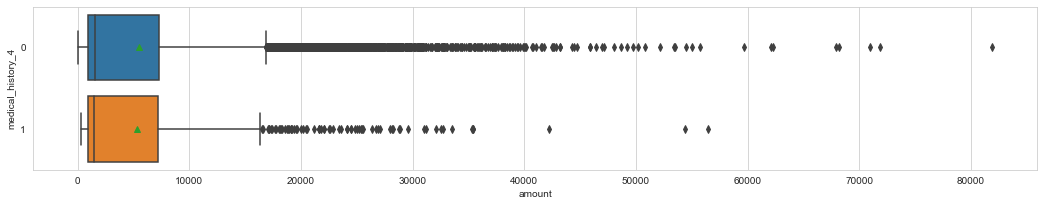

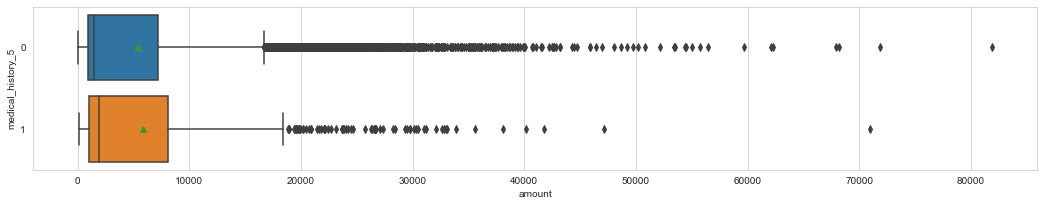

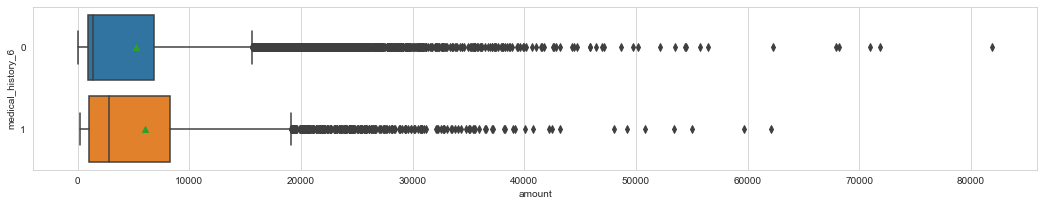

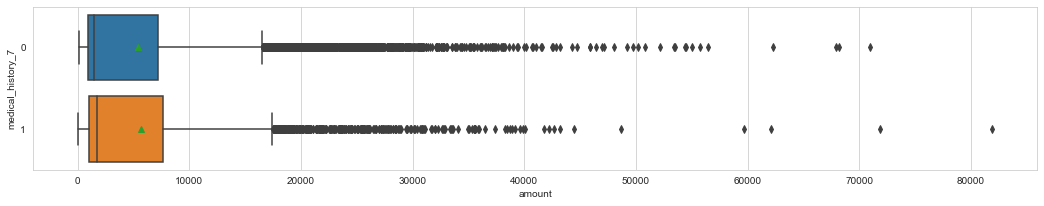

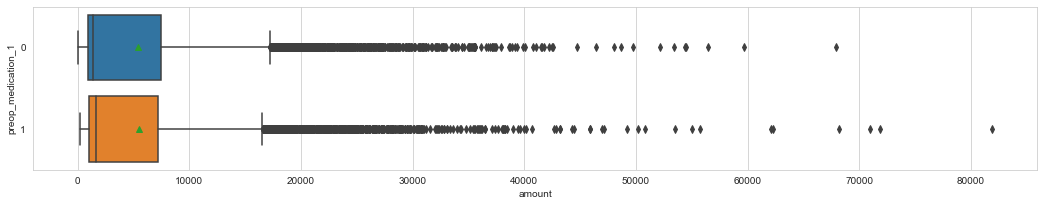

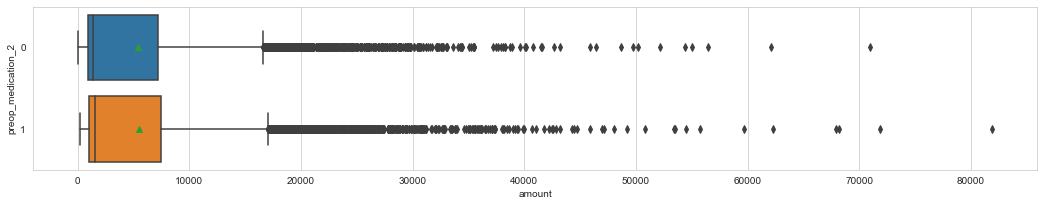

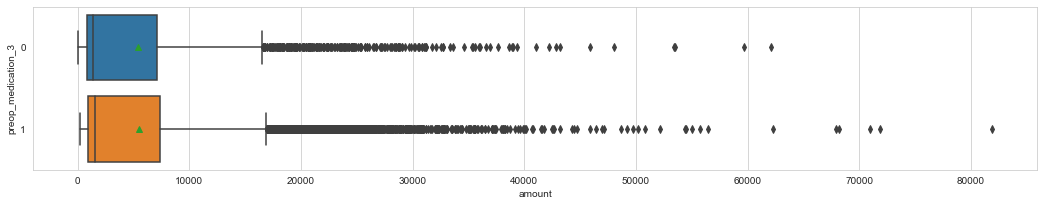

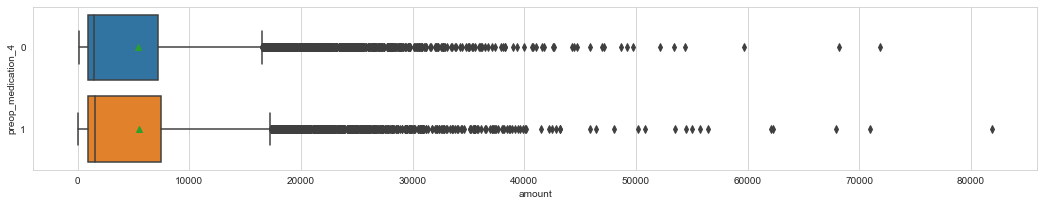

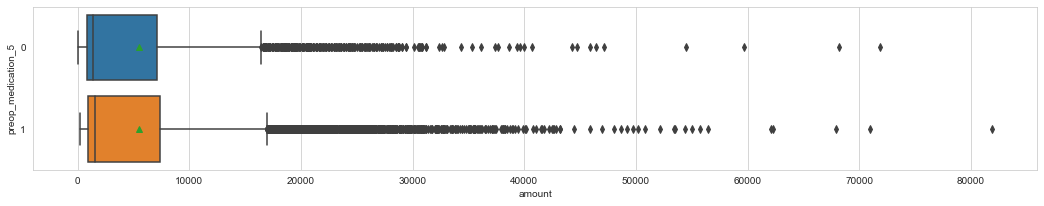

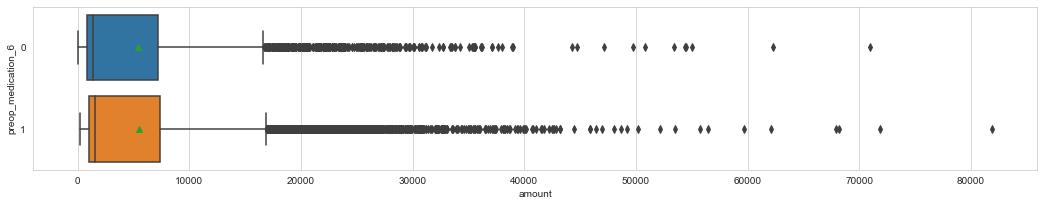

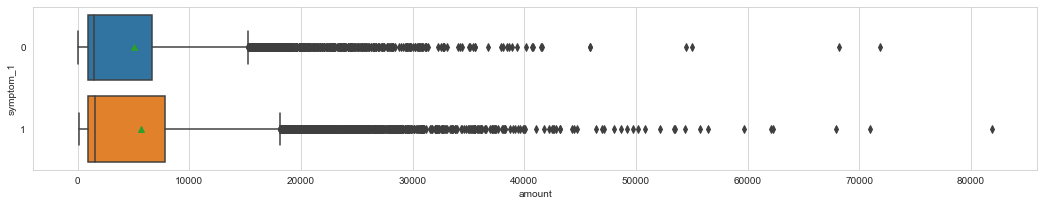

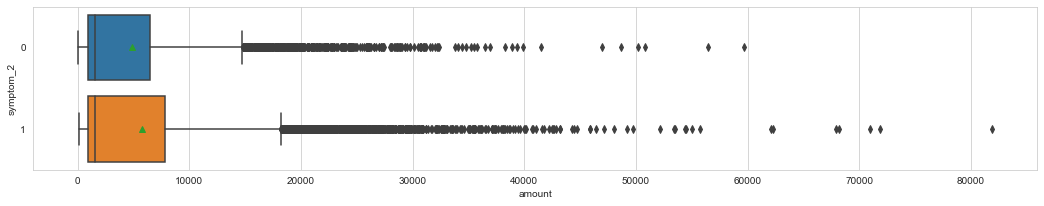

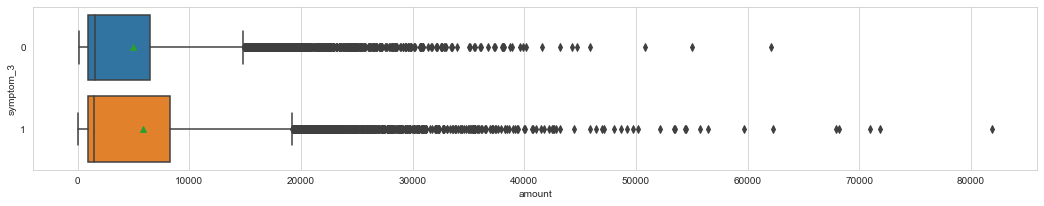

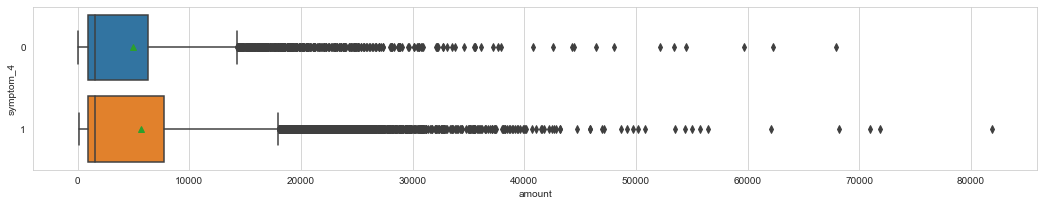

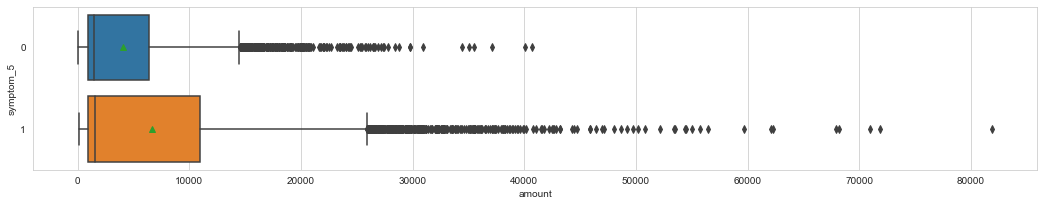

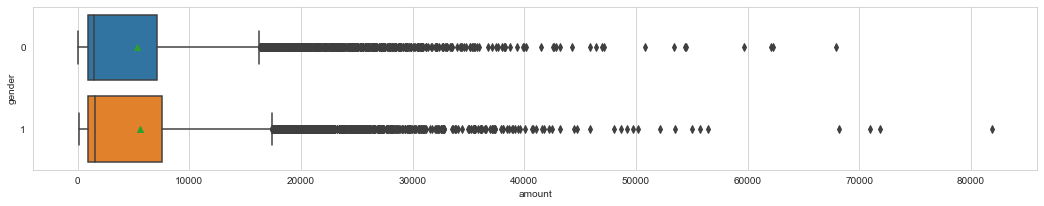

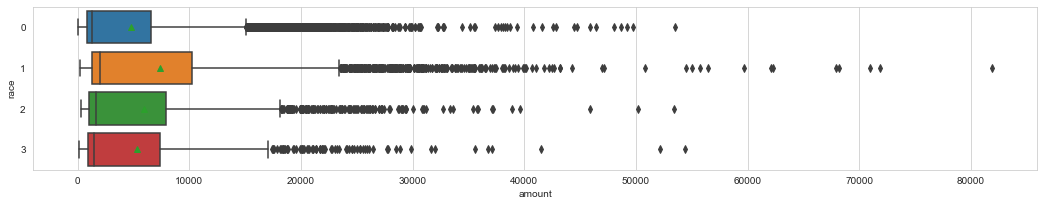

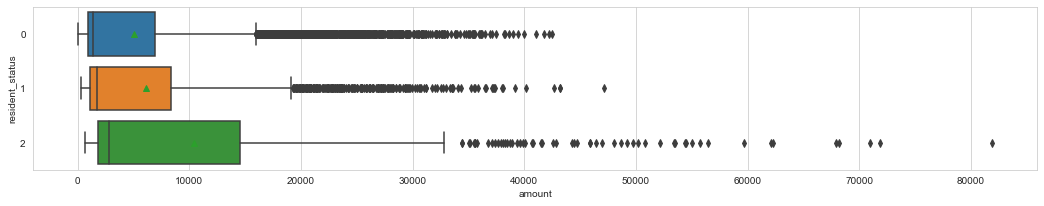

In [23]:
cat_cols = ['medical_history_1', 'medical_history_2',
               'medical_history_3', 'medical_history_4', 'medical_history_5',
               'medical_history_6', 'medical_history_7', 'preop_medication_1',
               'preop_medication_2', 'preop_medication_3', 'preop_medication_4',
               'preop_medication_5', 'preop_medication_6', 'symptom_1', 'symptom_2',
               'symptom_3', 'symptom_4', 'symptom_5', 'gender', 'race', 'resident_status']
plot_box(df_cat, cat_cols)   

## 4.1 Statistical testing to check difference in means

#### 4.1.1 Binary Variables

#### Normality

In [24]:
binary_df_list = []
binary_cat = ['medical_history_1', 'medical_history_2',
               'medical_history_3', 'medical_history_4', 'medical_history_5',
               'medical_history_6', 'medical_history_7', 'preop_medication_1',
               'preop_medication_2', 'preop_medication_3', 'preop_medication_4',
               'preop_medication_5', 'preop_medication_6', 'symptom_1', 'symptom_2',
               'symptom_3', 'symptom_4', 'symptom_5', 'gender']

for i in df_cat[binary_cat]:
    cat_subset_0 = df_cat[df_cat[i] == 0]
    cat_subset_1 = df_cat[df_cat[i] == 1]
    binary_df_list.append(cat_subset_0)
    binary_df_list.append(cat_subset_1)

In [25]:
binary_cat_shapiro_statistic = []
binary_cat_shapiro_pval = []

for i in binary_df_list:
    binary_cat_shapiro_scores = shapiro(i['amount'])
    binary_cat_shapiro_statistic.append(binary_cat_shapiro_scores[0])
    binary_cat_shapiro_pval.append(binary_cat_shapiro_scores[1])
    
binary_cat_2 = ['medical_history_1_0', 'medical_history_1_1',
               'medical_history_2_0', 'medical_history_2_1', 'medical_history_3_0',
               'medical_history_3_1', 'medical_history_4_0', 'medical_history_4_1',
              'medical_history_5_0','medical_history_5_1', 'medical_history_6_0',
              'medical_history_6_1','medical_history_7_0', 'medical_history_7_1',
              'preop_medication_1_0','preop_medication_1_1','preop_medication_2_0',
               'preop_medication_2_1', 'preop_medication_3_0', 'preop_medication_3_1',
              'preop_medication_4_0','preop_medication_4_1','preop_medication_5_0',
               'preop_medication_5_1', 'preop_medication_6_0', 'preop_medication_6_1',
              'symptom_1_0', 'symptom_1_1','symptom_2_0','symptom_2_1','symptom_3_0',
               'symptom_3_1', 'symptom_4_0', 'symptom_4_1','symptom_5_0','symptom_5_1',
              'gender_0','gender_1']
    
binary_cat_shapiro_df = pd.DataFrame({'Category':[i for i in binary_cat_2],
                                  
                                  'W-Statistic':binary_cat_shapiro_statistic,
                                    'p-value':binary_cat_shapiro_pval})

binary_cat_shapiro_df.round(2)

,Category,W-Statistic,p-value
0,medical_history_1_0,0.64,0.0
1,medical_history_1_1,0.77,0.0
2,medical_history_2_0,0.67,0.0
3,medical_history_2_1,0.67,0.0
4,medical_history_3_0,0.67,0.0
5,medical_history_3_1,0.68,0.0
6,medical_history_4_0,0.67,0.0
7,medical_history_4_1,0.65,0.0
8,medical_history_5_0,0.67,0.0
9,medical_history_5_1,0.68,0.0


#### Note: Distributions are not normal

#### Homegeneity of Variance

In [26]:
binary_cat_levene_statistic = []
binary_cat_levene_pval = []

for i in df_cat[binary_cat]:
    cat_subset_0 = df_cat[df_cat[i] == 0]
    cat_subset_1 = df_cat[df_cat[i] == 1]
    levene_test = levene(cat_subset_0.amount, cat_subset_1.amount)
    binary_cat_levene_statistic.append(levene_test[0])
    binary_cat_levene_pval.append(levene_test[1])

binary_cat_levene_df = pd.DataFrame({'Category':[i for i in binary_cat],
                                    'W-Statistic':binary_cat_levene_statistic,
                                    'p-value':binary_cat_levene_pval})

binary_cat_levene_df[binary_cat_levene_df['p-value'] > 0.05].round(2)

,Category,W-Statistic,p-value
1,medical_history_2,0.59,0.44
2,medical_history_3,0.00,0.96
3,medical_history_4,0.13,0.72
4,medical_history_5,0.88,0.35
6,medical_history_7,0.32,0.57
7,preop_medication_1,0.06,0.80
8,preop_medication_2,0.16,0.69
9,preop_medication_3,0.18,0.67
10,preop_medication_4,0.21,0.65
11,preop_medication_5,0.32,0.57


#### Note: Only the groups in the above categories have equal variances

#### Failed Assumption of normality, therefore using Mann-Whitney non-parametric test

In [27]:
binary_cat_mannwhitney_statistic = []
binary_cat_mannwhitney_pval = []

for i in df_cat[binary_cat]:
    cat_subset_0 = df_cat[df_cat[i] == 0]
    cat_subset_1 = df_cat[df_cat[i] == 1]
    mannwhitney_utest = stats.mannwhitneyu(cat_subset_0.amount, cat_subset_1.amount)
    binary_cat_mannwhitney_statistic.append(mannwhitney_utest[0])
    binary_cat_mannwhitney_pval.append(mannwhitney_utest[1])

binary_cat_mannwhitney_df = pd.DataFrame({'Category':[i for i in binary_cat],
                                    'U-Statistic':binary_cat_mannwhitney_statistic,
                                    'p-value':binary_cat_mannwhitney_pval})

binary_cat_mannwhitney_df[binary_cat_mannwhitney_df['p-value'] < 0.05].round(2)

,Category,U-Statistic,p-value
0,medical_history_1,10894056.5,0.00
1,medical_history_2,18126948.5,0.00
2,medical_history_3,10310800.0,0.00
4,medical_history_5,4649644.0,0.00
5,medical_history_6,15194888.0,0.00
6,medical_history_7,16075836.5,0.00
7,preop_medication_1,21699755.0,0.00
8,preop_medication_2,20901962.5,0.00
9,preop_medication_3,12654443.5,0.00
11,preop_medication_5,12962180.5,0.00


### 4.1.2 Non Binary Variable - Race

#### Normality Assumption Check

In [28]:
race_df_list = []
cat_subset_0 = df_cat[df_cat['race'] == 0]
cat_subset_1 = df_cat[df_cat['race'] == 1]
cat_subset_2 = df_cat[df_cat['race'] == 2]
cat_subset_3 = df_cat[df_cat['race'] == 3]
race_df_list.append(cat_subset_0)
race_df_list.append(cat_subset_1)
race_df_list.append(cat_subset_2)
race_df_list.append(cat_subset_3)

race_shapiro_statistic = []
race_shapiro_pval = []

for i in race_df_list:
    race_shapiro_scores = shapiro(i['amount'])
    race_shapiro_statistic.append(race_shapiro_scores[0])
    race_shapiro_pval.append(race_shapiro_scores[1])
    
race_groups = ['race_0', 'race_1', 'race_2', 'race_3']
    
race_shapiro_df = pd.DataFrame({'Race':[i for i in race_groups],
                                  'W-Statistic':race_shapiro_statistic,
                                    'p-value':race_shapiro_pval})

race_shapiro_df.round(2)

,Race,W-Statistic,p-value
0,race_0,0.68,0.0
1,race_1,0.68,0.0
2,race_2,0.69,0.0
3,race_3,0.66,0.0


#### Note: Distribution is not normal

#### Homegeneity of Variance

In [29]:
race_levene_statistic = []
race_levene_pval = []

cat_subset_0 = df_cat[df_cat['race'] == 0]
cat_subset_1 = df_cat[df_cat['race'] == 1]
cat_subset_2 = df_cat[df_cat['race'] == 2]
cat_subset_3 = df_cat[df_cat['race'] == 3]
levene_test = levene(cat_subset_0.amount, cat_subset_1.amount, cat_subset_2.amount, cat_subset_3.amount)
race_levene_statistic.append(levene_test[0])
race_levene_pval.append(levene_test[1])

race_levene_df = pd.DataFrame({'Category':'Race',
                                    'W-Statistic':race_levene_statistic,
                                    'p-value':race_levene_pval})

race_levene_df.round(2)

,Category,W-Statistic,p-value
0,Race,60.8,0.0


#### The 4 groups have equal variances

#### Kruskal-Wallis Test as a nonparametric alternative to the one-way ANOVA.

In [30]:
kw_race_stat = []
kw_race_pval = []

kw_test = stats.kruskal(cat_subset_0.amount, cat_subset_1.amount, cat_subset_2.amount, cat_subset_3.amount)
kw_race_stat.append(kw_test[0])
kw_race_pval.append(kw_test[1])

kw_race_df = pd.DataFrame({'Category':'Race',
                                    'H-Statistic':kw_race_stat,
                                    'p-value':kw_race_pval})
kw_race_df.round(2)

,Category,H-Statistic,p-value
0,Race,530.25,0.0


### 4.1.3 Non Binary Variable - Resident Status

In [31]:
rs_df_list = []
cat_subset_0 = df_cat[df_cat['resident_status'] == 0]
cat_subset_1 = df_cat[df_cat['resident_status'] == 1]
cat_subset_2 = df_cat[df_cat['resident_status'] == 2]
rs_df_list.append(cat_subset_0)
rs_df_list.append(cat_subset_1)
rs_df_list.append(cat_subset_2)

rs_shapiro_statistic = []
rs_shapiro_pval = []

for i in rs_df_list:
    rs_shapiro_scores = shapiro(i['amount'])
    rs_shapiro_statistic.append(rs_shapiro_scores[0])
    rs_shapiro_pval.append(rs_shapiro_scores[1])
    
rs_groups = ['rs_0', 'rs_1', 'rs_2']
    
rs_shapiro_df = pd.DataFrame({'Resident Status':[i for i in rs_groups],
                                  'W-Statistic':rs_shapiro_statistic,
                                    'p-value':rs_shapiro_pval})

rs_shapiro_df.round(2)

,Resident Status,W-Statistic,p-value
0,rs_0,0.69,0.0
1,rs_1,0.69,0.0
2,rs_2,0.68,0.0


#### Note: Distribution is not normal

#### Homegeneity of Variance

In [32]:
rs_levene_statistic = []
rs_levene_pval = []
levene_test = levene(cat_subset_0.amount, cat_subset_1.amount, cat_subset_2.amount)
rs_levene_statistic.append(levene_test[0])
rs_levene_pval.append(levene_test[1])

rs_levene_df = pd.DataFrame({'Category':'Resident Status',
                                    'W-Statistic':rs_levene_statistic,
                                    'p-value':rs_levene_pval})

rs_levene_df.round(2)

,Category,W-Statistic,p-value
0,Resident Status,116.9,0.0


#### The 3 groups have equal variances

#### Kruskal-Wallis Test as a nonparametric alternative to the one-way ANOVA.

In [33]:
kw_rs_stat = []
kw_rs_pval = []

kw_test = stats.kruskal(cat_subset_0.amount, cat_subset_1.amount, cat_subset_2.amount)
kw_rs_stat.append(kw_test[0])
kw_rs_pval.append(kw_test[1])

kw_rs_df = pd.DataFrame({'Category':'Resident Status',
                                    'H-Statistic':kw_rs_stat,
                                    'p-value':kw_rs_pval})
kw_rs_df.round(2)

,Category,H-Statistic,p-value
0,Resident Status,372.0,0.0


## Main drivers of cost derived

1. Positive Linear Relationship
    1. Age
    2. Extent of Medical History
    3. Number of presenting symptoms
    
    
2. Mann-Whitney U Test

    0      medical_history_1
    
    1      medical_history_2
    
    2      medical_history_3
    
    3      medical_history_5
    
    4      medical_history_6
    
    5      medical_history_7
    
    6     preop_medication_1
    
    7     preop_medication_2
    
    8     preop_medication_3
    
    9     preop_medication_5
    
    10    preop_medication_6
    
    11             symptom_1
    
    12             symptom_2
    
    13             symptom_3
    
    14             symptom_5
    
    15                gender
    
    
    
3. Kruskal-Wallis Test
    1. Race
    2. Resident Status